In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../result/time-series-data/t2_stable_enriched.csv")



In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation between all configuration and metrics")
plt.tight_layout()
plt.show()

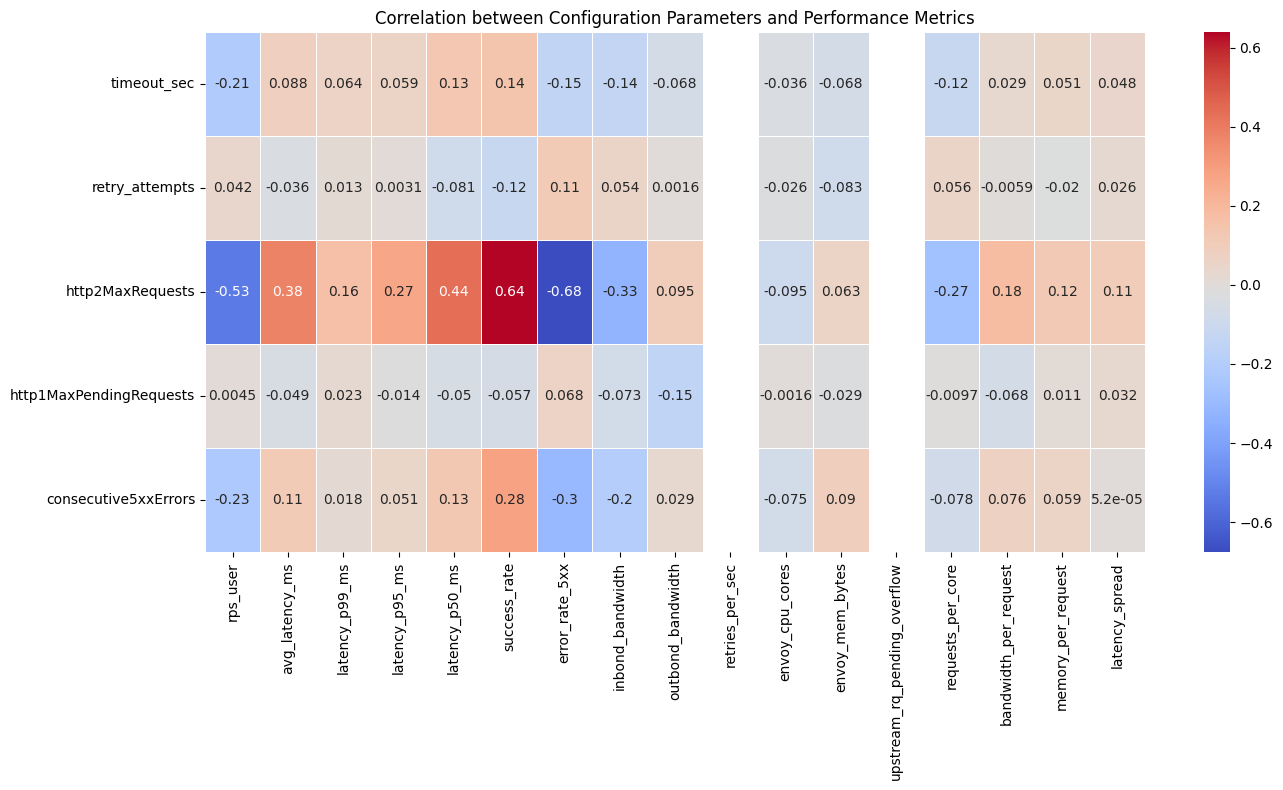

In [12]:
config_cols = ['timeout_sec', 'retry_attempts', 'http2MaxRequests', 'http1MaxPendingRequests', 'consecutive5xxErrors']
metric_cols = ['rps_user', 'avg_latency_ms', 'latency_p99_ms', 'latency_p95_ms', 'latency_p50_ms',
               'success_rate', 'error_rate_5xx', 'inbond_bandwidth', 'outbond_bandwidth', 'retries_per_sec',
               'envoy_cpu_cores', 'envoy_mem_bytes', 'upstream_rq_pending_overflow', 'requests_per_core', 'bandwidth_per_request', 'memory_per_request', 'latency_spread']

# Ensure numeric only
numeric_df = df.select_dtypes(include=[np.number])

# Compute full correlation matrix
corr = numeric_df.corr()

# Slice only metric rows vs config columns
filtered_corr = corr.loc[config_cols, metric_cols]

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation between Configuration Parameters and Performance Metrics")
plt.tight_layout()
plt.show()

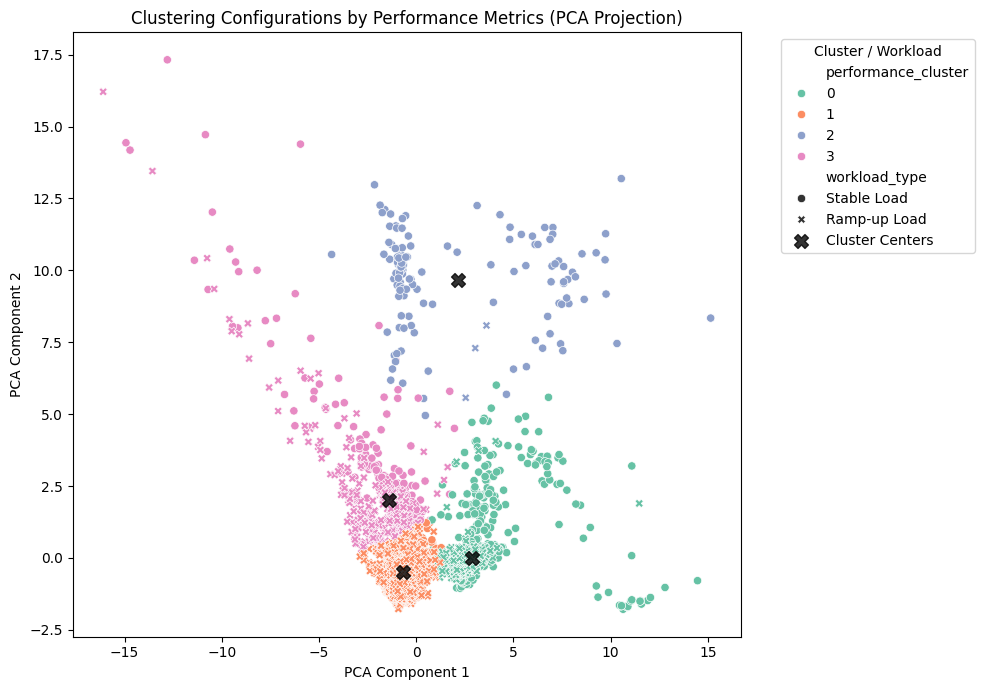

In [14]:
features = [
    "rps_user", "success_rate", "error_rate_5xx", "latency_p99_ms", "requests_per_core",
    "bandwidth_per_request", "memory_per_request", "latency_spread"
]

X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['performance_cluster'] = clusters

# Reduce dimensions for plotting
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]
centers_pca = pca.transform(kmeans.cluster_centers_)

# Visualize clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="performance_cluster", palette="Set2", style="workload_type")
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, alpha=0.8, marker='X', label='Cluster Centers')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering Configurations by Performance Metrics (PCA Projection)")
plt.legend(title="Cluster / Workload", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [2]:
# Step-by-step execution as described


from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


# Step 1: Filter high-performance rows based on thresholds
high_perf_df = df[
    (df["success_rate"] >= 0.85) &
    (df["latency_p99_ms"] <= 8000) &
    (df["error_rate_5xx"] <= 0.10)
]

# Step 2: Analyze dominant configurations
config_columns = ["timeout_sec", "retry_attempts", "http2MaxRequests", "http1MaxPendingRequests", "consecutive5xxErrors"]
config_dominance = high_perf_df[config_columns].apply(pd.Series.value_counts).fillna(0)

# Step 3: Feature importance only on high-performance subset
metric_columns = [
    "rps_user", "avg_latency_ms", "latency_p99_ms", "latency_p95_ms", "latency_p50_ms",
    "success_rate", "error_rate_5xx", "inbond_bandwidth", "outbond_bandwidth",
    "retries_per_sec", "envoy_cpu_cores", "envoy_mem_bytes", "upstream_rq_pending_overflow",
    "requests_per_core", "bandwidth_per_request", "memory_per_request", "latency_spread"
]

X = high_perf_df[metric_columns].fillna(0)
feature_importance_results = {}

# For simplicity, analyze importance for predicting 'http2MaxRequests' as a representative config
y = high_perf_df["http2MaxRequests"]
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)



/tmp/ipykernel_209279/3955973539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:10], y=importances.index[:10], palette="viridis")


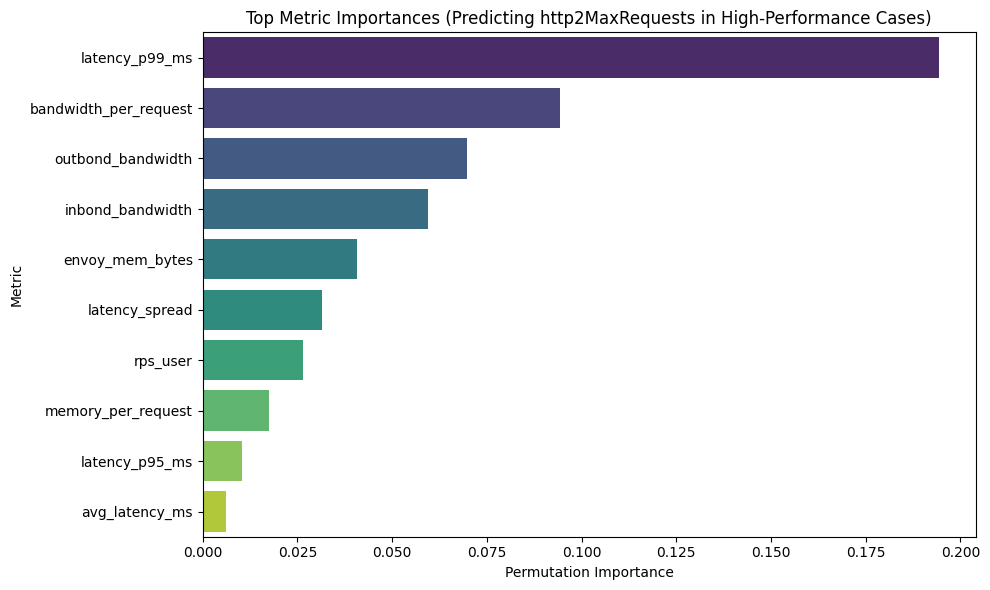

<Figure size 1200x600 with 0 Axes>

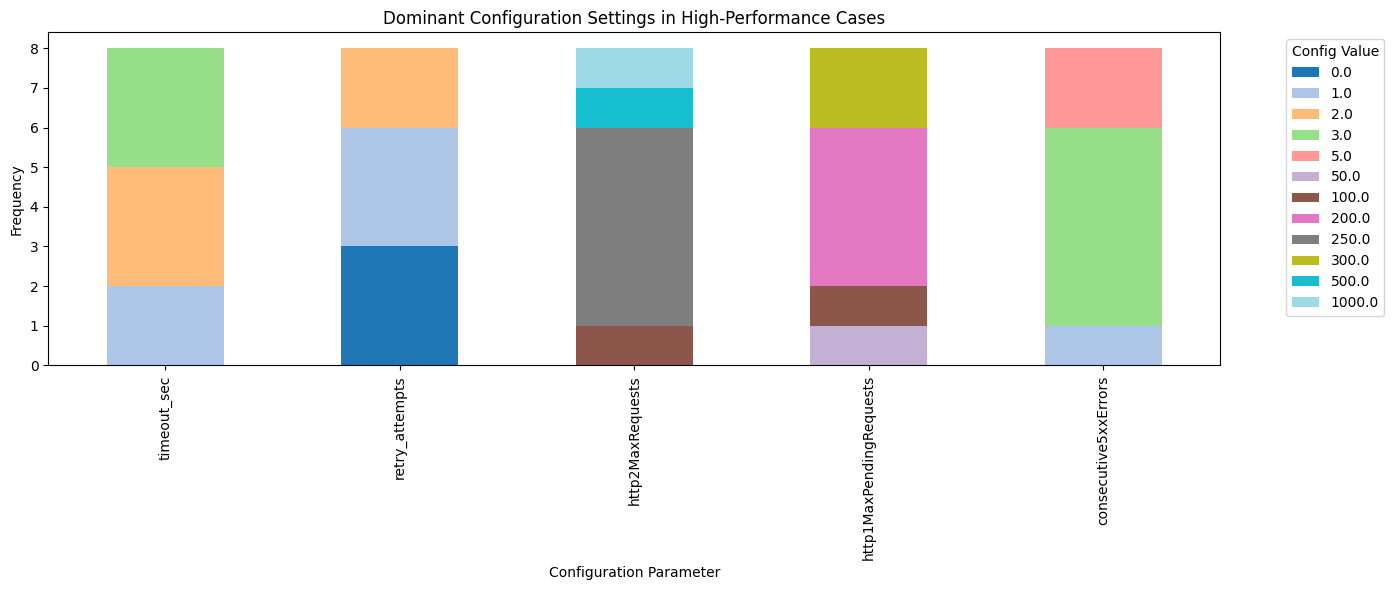

(['http2MaxRequests', 'http1MaxPendingRequests', 'timeout_sec'],
 ['latency_p99_ms',
  'bandwidth_per_request',
  'outbond_bandwidth',
  'inbond_bandwidth',
  'envoy_mem_bytes',
  'latency_spread',
  'rps_user',
  'memory_per_request'])

In [10]:
# Visualization: Feature importance for high-performance configs
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10], palette="viridis")
plt.title("Top Metric Importances (Predicting http2MaxRequests in High-Performance Cases)")
plt.xlabel("Permutation Importance")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

# Visualization: Configuration dominance in high performance
config_dominance_plot = config_dominance.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
config_dominance.T.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title("Dominant Configuration Settings in High-Performance Cases")
plt.ylabel("Frequency")
plt.xlabel("Configuration Parameter")
plt.legend(title="Config Value", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Extract top 3 config columns based on overall importance in high performance
config_variability = high_perf_df[config_columns].nunique().sort_values(ascending=False)
top_3_configs = config_variability.index[:3].tolist()
top_metrics = importances.index[:8].tolist()

(top_3_configs, top_metrics)